In [33]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from math import atan, sin, cos
# you are only allowed to import numpy
# for further math calculations!!
import numpy as np


In [34]:
vertices = np.array([
    [-1, -1, -1],   # 0
    [-1, -1, 1],    # 1
    [-1, 1, -1],    # 2
    [-1, 1, 1],     # 3
    [1, -1, -1],    # 4
    [1, -1, 1],     # 5
    [1, 1, -1],     # 6
    [1, 1, 1],      # 7
])

# A set of vertex pairs that are connected by edges
edges = np.array([
    (0, 1), (0, 2), (0, 4),
    (1, 3), (1, 5), (2, 3),
    (2, 6), (3, 7), (4, 5),
    (4, 6), (5, 7), (6, 7)
])


In [35]:
# these functions require non-homogenous coordinates
def show_3d(vertices, edges):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax = fig.gca(projection='3d')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    ax.set_box_aspect([1, 1, 1])

    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot(
            [p1[0], p2[0]],
            [p1[1], p2[1]],
            [p1[2], p2[2]]
        )

    plt.show()


def show_2d(vertices, edges, size):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(0, size[0])
    ax.set_ylim(0, size[1])

    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot(
            [p1[0], p2[0]],
            [p1[1], p2[1]]
        )
    plt.show()


In [36]:
def normalize(elements):
    norm = sum(elem**2 for elem in elements) ** 0.5
    return np.array([elem / norm for elem in elements])


def expand_to_4x4(m):
    m = [row.tolist() + [0] for row in m]
    m.append([0, 0, 0, 1])
    return np.array(m)


def get_rotation_matrix(axis, angle):
    axis = np.array(axis)
    axis = normalize(axis) # normalizing for non-normalized input
    ux, uy, uz = axis
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)

    return np.array([
        [cos_a + ux**2*(1-cos_a), ux*uy*(1-cos_a)-uz*sin_a, ux*uz*(1-cos_a)+uy*sin_a],
        [uy*ux*(1-cos_a) + uz*sin_a, cos_a + uy**2*(1-cos_a), uy*uz*(1-cos_a) - ux*sin_a],
        [uz*ux*(1-cos_a) - uy*sin_a, uz*uy*(1-cos_a) + ux*sin_a, cos_a + uz**2*(1-cos_a)]
    ])


def get_translation_matrix(x, y, z):
    return np.array([
        [1, 0, 0, -x],
        [0, 1, 0, -y],
        [0, 0, 1, -z],
        [0, 0, 0, 1],
    ])


def get_extrinsic_matrix(position, orientation):
    x, y, z = orientation

    rx = get_rotation_matrix([1, 0, 0], x)
    ry = get_rotation_matrix([0, 1, 0], y)
    rz = get_rotation_matrix([0, 0, 1], z)
    r = rz @ ry @ rx

    # expand dimension for calculating
    r_4x4 = expand_to_4x4(r)

    t = get_translation_matrix(*position)
    extrinsic = r_4x4 @ t
    return extrinsic


def get_intrinsic_matrix(f, s):
    '''
    Make a function get_intrinsic_matrix(f,s) that creates the full intrinsic 
    transformation including the projection matrix 3x4 P, so that we get a 3x4 matrix overall. 
    Again, this uses homogenous coordinates. 

    Parameters:
        f (float) : focal length
        s (float, float) : normalized pricipal points :: cx, cy 
    '''
    cx, cy = s
    k = np.array([
        [-f, 0, cx],
        [0, -f, cy],
        [0, 0, 1]
    ])

    projection = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ])

    return k @ projection


def to_homogenous(points):
    points = [row.tolist() + [1] for row in points]
    point = [1] * len(points[0])
    points.append(point)
    return np.array(points)


def from_homogenous(points):
    return points[:, :-1] / points[:, [-1]]

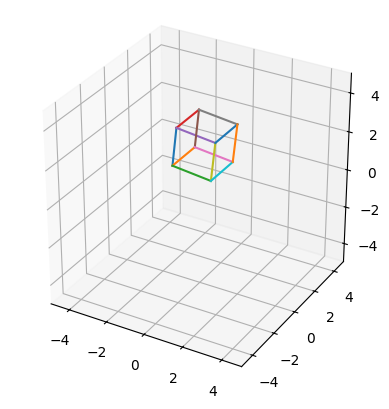

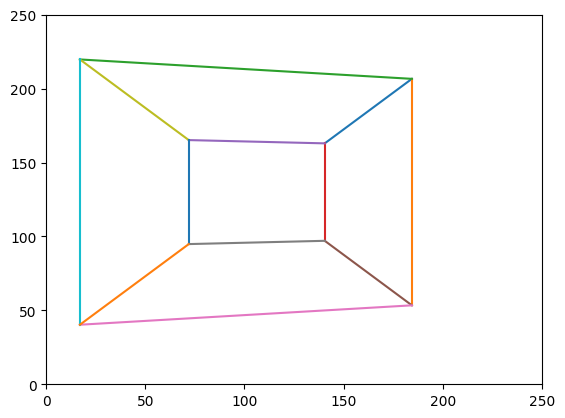

In [37]:
%matplotlib inline

def assignment2():
    camera_position = [0, 0, -2.4]
    camera_orientation = [0, 0.11, 0]
    
    extrinsic = get_extrinsic_matrix(camera_position, camera_orientation)
    vertices_h = to_homogenous(vertices)
    camera_coords = (extrinsic @ vertices_h.T).T

    # after applying extrinsic
    show_3d(camera_coords, edges)

    f = 0.46
    s = (0.48, 0.52)
    pixel_size = 250
    intrinsic = get_intrinsic_matrix(f, s)
    projected = (intrinsic @ camera_coords.T).T
    projected_2d = from_homogenous(projected) 
    projected_2d = projected_2d * pixel_size
    size = (pixel_size, pixel_size)

    show_2d(projected_2d, edges, size)

assignment2()

In [38]:
%matplotlib notebook

from matplotlib import animation
from IPython.display import HTML


def to_cartesian_singlepoint(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def init_ax(ax, size=(3, 3)):
    ax.clear()
    ax.set_xlim(0, size[0])
    ax.set_ylim(0, size[1])
    return ax


def get_orientation_matrix(camera_position, target_position, up=np.array([0, 0, 1])):
    forward = target_position - camera_position
    forward = normalize(forward)
    
    right = np.cross(forward, up)
    right = normalize(right)

    true_up = np.cross(right, forward)
    R = np.column_stack((right, true_up, -forward))
    return R


def update(frame, frame_length, ax: plt.Axes):
    size = 250
    ax = init_ax(ax, (size, size))

    theta = np.pi * 0.45
    phi = np.pi * ((frame+1) / frame_length)
    camera_position = to_cartesian_singlepoint(2.5, theta, phi)

    r_3x3 = get_orientation_matrix(camera_position, np.array([0, 0, 0]))
    r_4x4 = expand_to_4x4(r_3x3.T)
    t = get_translation_matrix(*camera_position)
    extrinsic = r_4x4 @ t

    coords = to_homogenous(vertices)
    camera_coords = (extrinsic @ coords.T).T

    intrinsic = get_intrinsic_matrix(f=0.46, s=(0.48, 0.52))
    projected = (intrinsic @ camera_coords.T).T
    projected_2d = from_homogenous(projected)
    projected_2d = projected_2d * size

    items = []
    for edge in edges:
        p1 = projected_2d[edge[0]]
        p2 = projected_2d[edge[1]]
        item = ax.plot(
            [p1[0], p2[0]],
            [p1[1], p2[1]]
        )
        items.append(item)

    title_text = ax.text(0.5, 1.05, frame, transform=ax.transAxes, ha="center", fontsize=12)
    return [items, title_text]


def assignment2_bonus():
    '''
    Bonus (20 points): 
    Insert code that rotates the camera around the cube from left to right and shows the resulting views 
    [you can do an animation, or the individual views, both are fine!] 
    '''

    figure = plt.figure()
    ax = figure.gca()
    frame_length = 30

    ani = animation.FuncAnimation(
        figure,
        lambda frame: update(frame, frame_length, ax),
        frames=frame_length
    )
    return HTML(ani.to_jshtml())

assignment2_bonus()

<IPython.core.display.Javascript object>